# Recursive forecasting example

In this notebook we will show how to use trend features in a recursive forecasting workflow where we also have features built from the target (e.g., lag & window features).

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [2]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

## Plot the data

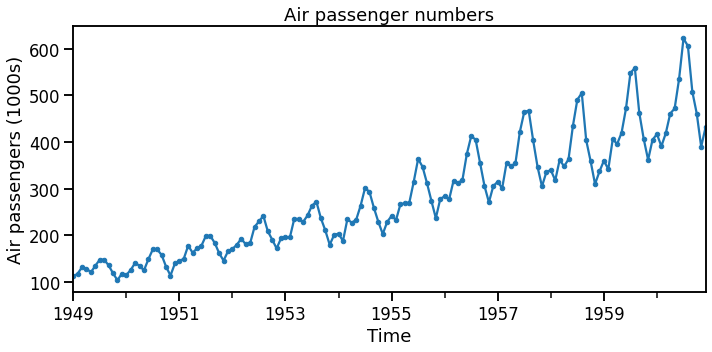

In [3]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

# Let's build some forecasts!

Let's build a recursive forecast and see how our trend feature can help!

In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [5]:
from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.pipeline import Pipeline
from sktime.transformations.series.time_since import TimeSince
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.fourier import FourierFeatures
from feature_engine.creation import CyclicalFeatures

In [6]:
# The data is monthly, let's work with pandas Period.
df = data.copy()
df.index = df.index.to_period("M")
df.head()

,y
ds,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


Prepare our transformers. We start with features built from the time index where we know the values in the past and the future. In this case, let's consider only the time feature to capture the trend.

In [7]:
time_since_transformer = TimeSince(keep_original_columns=False)

datetime = DateTimeFeatures(manual_selection=["month_of_year" ,
                                              "year",
                                              "quarter_of_year"])

fourier = FourierFeatures(sp_list=[12], fourier_terms_list=[3])

cyclicf = CyclicalFeatures(variables=["month_of_year", "quarter_of_year"])

In [8]:
# Create a pipeline for all our features excluding 
# lags and windows where we need access to the 
# training period.
pipe = Pipeline([
    ('trend', time_since_transformer),
    ('dt', datetime),
    ('fourier', fourier),
    ('cyclicf', cyclicf),
])

In [9]:
pipe.fit_transform(df)

,time_since_1949-01,month_of_year,year,quarter_of_year,sin_12_1,cos_12_1,sin_12_2,cos_12_2,sin_12_3,cos_12_3,month_of_year_sin,month_of_year_cos,quarter_of_year_sin,quarter_of_year_cos
ds,,,,,,,,,,,,,,
1949-01,0,1,1949,1,0.000000,1.000000e+00,0.000000e+00,1.0,0.000000e+00,1.000000e+00,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17
1949-02,1,2,1949,1,0.500000,8.660254e-01,8.660254e-01,0.5,1.000000e+00,6.123234e-17,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17
1949-03,2,3,1949,1,0.866025,5.000000e-01,8.660254e-01,-0.5,1.224647e-16,-1.000000e+00,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
1949-04,3,4,1949,2,1.000000,6.123234e-17,1.224647e-16,-1.0,-1.000000e+00,-1.836970e-16,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00
1949-05,4,5,1949,2,0.866025,-5.000000e-01,-8.660254e-01,-0.5,-2.449294e-16,1.000000e+00,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08,139,8,1960,3,-0.500000,-8.660254e-01,8.660254e-01,0.5,-1.000000e+00,-1.028765e-14,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16
1960-09,140,9,1960,3,-0.866025,-5.000000e-01,8.660254e-01,-0.5,1.274375e-14,1.000000e+00,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16
1960-10,141,10,1960,4,-1.000000,-1.175970e-14,2.351941e-14,-1.0,1.000000e+00,2.106826e-14,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00


Let's create transformers that will build features from the target variable. This will always be in a separate pipeline because for recursive forecasting we need to re-compute these features on each forecast step.

In [10]:
# Features computed from the target.
# Compute lag and window features.
lag_window_transformer = WindowSummarizer(
    lag_feature={
        "lag": [1],  # Lag features.
        "mean": [[1, 12]],  # [[lag, window size]]
    },
    target_cols=["y"],
    truncate="bfill", # Backfill missing values from lagging and windowing.
    )

Let's build a recursive forecast.

In [11]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split                                                    
forecast_start_period = pd.Period("1959-10", freq="M")
# Define number of steps to forecast.
num_of_forecast_steps = 36
# Define the target variable in our data.
target = "y"
# Define the model.
model = LinearRegression()
# Set flag which will determine if model is fit once.
fit_once = True # if True fit model once.
                # if False fit model on each iteration.

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.period_range(forecast_start_period, 
                                   periods=num_of_forecast_steps,
                                   freq="M")

# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[:forecast_start_period-1].copy()
df_test = df.loc[forecast_start_period:].copy()

# --- CREATE DYNAMIC FORECASTING DATAFRAME  --- #
# We will use this dataframe to recursively append
# & write our forecasts to and computer our lag
# and window features from the target. It contains
# data in the training period and forecast period which
# is needed for some transformers (e.g., lags and windows).
df_forecast = df.copy() 
df_forecast.loc[forecast_start_period:, [target]] = np.NaN

# `df_forecast = df.copy()` above does not guarantee the index
# covers forecast horizon. Extend `df_forecast` to include 
# forecast horizon just in case it does not already.
# This is needed when we want to predict into the forecast 
# horizon and it is outside of the dataframe we started with.
diff_index = set(forecast_horizon) - set(df_forecast.index)
if any(diff_index):
    diff_index = pd.PeriodIndex(diff_index).sort_values()
    # extend index to cover the forecast horizon
    df_forecast = pd.concat([
                      df_forecast,
                      pd.DataFrame(index=diff_index)
                     ], 
                     axis=1)

# --- FEATURE ENGINEERING FOR FUTURE KNOWN FEATURES --- #
# Here, we create any features where we already know 
# the feature value in the forecast horizon (i.e., the future).
# Hence, we can compute them just once and outside of the
# recursive forecasting loop that will follow.

# Create all our features not related to windows and lags
# in the training set
X_train_ = pipe.fit_transform(df_train)

# Create window and lag features in the training set
X_lag_train_ = lag_window_transformer.fit_transform(df_train[[target]])

# Create X_train and y_train
X_train = pd.concat([X_train_, X_lag_train_], axis=1)
y_train = df_train[[target]]

# Train one-step ahead forecast model
model.fit(X_train, y_train)

# Create all our features not related to windows and lags 
# in the forecast horizon
X_test_ = pipe.transform(df_forecast.loc[forecast_horizon])

# --- RECURSIVE FORECASTING LOOP --- #
for forecast_period in forecast_horizon:    
    # --- FEATURE ENGINEERING FROM TARGET --- #
    # Create lag & window features in the forecast horizon
    X_lag_all_ = lag_window_transformer.transform(df_forecast.loc[:forecast_period, [target]])
    X_lag_test_ = X_lag_all_.loc[[forecast_period]]
    
    # Create the completed test set
    X_test = pd.concat([
                        X_test_.loc[[forecast_period]], # all other features
                        X_lag_test_
                       ], axis=1)
    
    # Predict one step ahead. 
    y_pred = model.predict(X_test)
    
    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_forecast`. This `df_forecast`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_forecast.loc[forecast_period, target] = y_pred[0]

In [12]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
# Create predictions on the training set 
# using the one step ahead forecast model.
# Useful to plot when debugging models.
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame({"y":y_forecast_train.flatten()}, index=X_train.index)

In [13]:
# --- CONVENIENT POST PROCESSING--- #
# Fill in last forecast in the dataframe that contains
# target and features.
df_forecast.loc[forecast_period, target] = y_pred[0]

# Retreive forecast and actuals
y_forecast = df_forecast.loc[forecast_horizon, target]
y_train = df.loc[:forecast_start_period, target]
y_test = df.loc[forecast_start_period:, target]

Text(0.5, 1.0, 'Air passenger numbers')

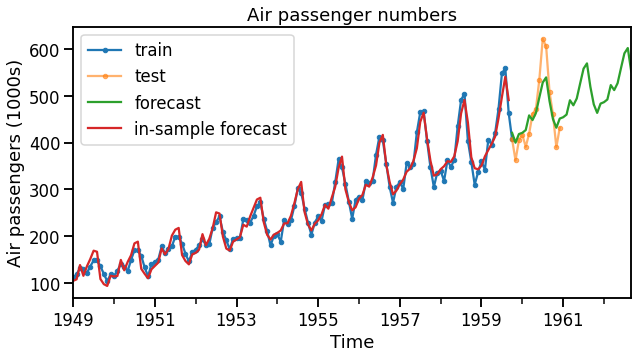

In [14]:
# --- PLOTTING --- #

# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])

# Plot training set.
y_train.plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")

Let's compute the RMSE of this forecast.

In [15]:
# Compute error metrics.
# from sklearn.metrics import mean_squared_error
# mean_squared_error(y_forecast[y_test.index, y_test.loc[y_forecast.index], squared=False)

What about LASSO and Ridge which need feature scaling?

We can conveniently attach the feature scaling step to the model using a pipeline.

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
                        ('scaler', MinMaxScaler()), 
                        ('model', Ridge()),
])

This model with feature scaling can now be inserted at the top of the recursive forecasting code block.

We can now implement the time feature to capture trend alongside other features in a recursive forecasting workflow. We can see that the time feature can help capture the trend in the data when using linear models.

Feel free to change the dates, try different models, and different features!